In [1]:
import numpy as np

# Question 1

In [2]:
from keras.datasets import fashion_mnist

2025-02-26 12:04:32.078486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
np.amin(train_labels), np.amax(train_labels)

(0, 9)

In [5]:
import matplotlib.pyplot as plt

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
def plot_images(images, labels):
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[np.random.choice(np.where(labels==i)[0])], cmap='gray')
        plt.title(class_names[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

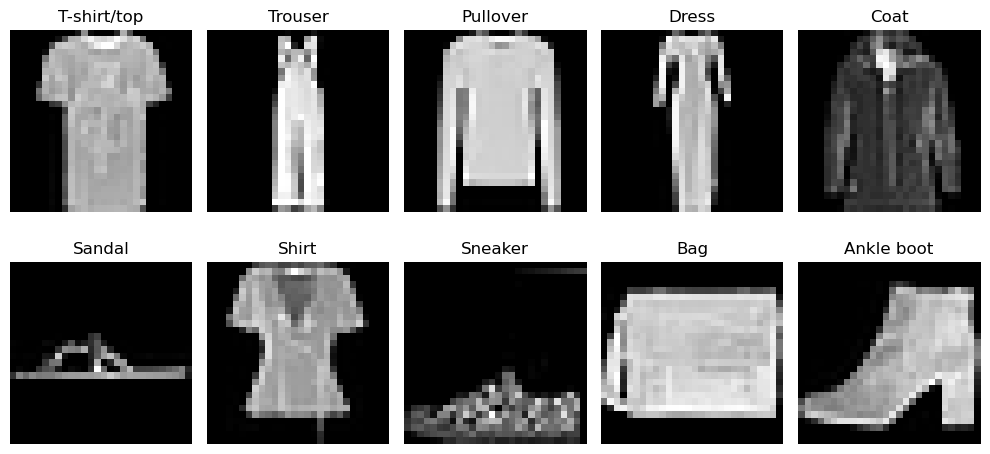

In [8]:
plot_images(train_images, train_labels)

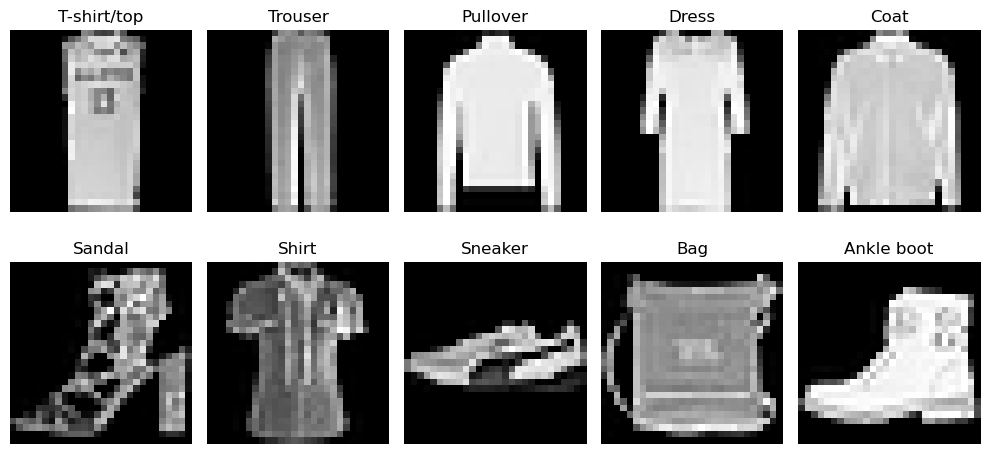

In [9]:
plot_images(test_images, test_labels)